In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['animation.html'] = 'html5'

import sys
import time
import math

In [2]:
# Time step progress bar
def update_progress_bar(current, total):
    sys.stdout.write('\rTime step: [{:<50}] {:.0f}/{:.0f} ({:.2f}%)'.format('=' * int(current/total * 50), current, total, current*100/total))
    sys.stdout.flush()

## Boundary conditions:

The stream function vorticity formulation works for two-dimensional incompressible flows to eliminate the pressure gradient term. As Prof. Suman Chakraborty had put it, the approach parallels "if you have a headache, cut off the head". The boundary conditions are to be respectively derived using the resulting Poisson's equation for stream-function and the advection-diffusion Vorticity transport equation, both of which form the governing differential equations for this formulation.

For the Lid-Driven cavity problem, the velocity and SF-Vorticity boundary conditions are shown below.

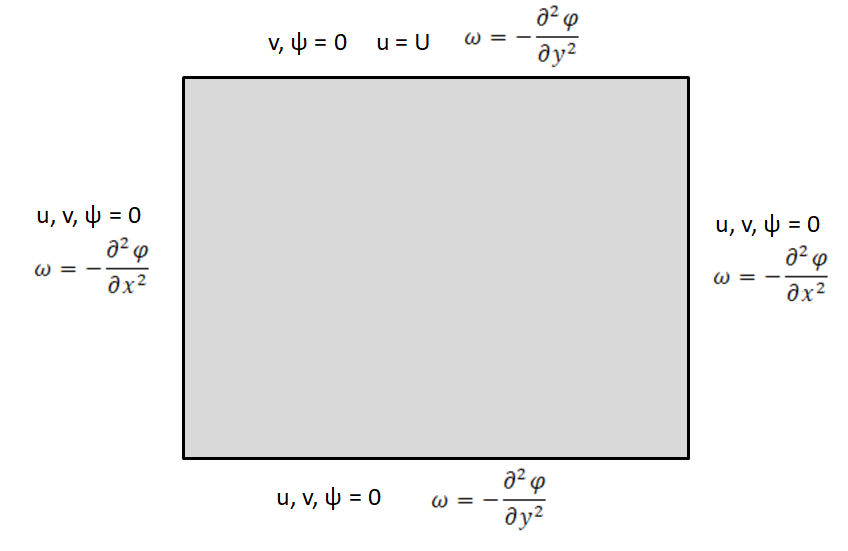


## Discretisation
### 1. Top wall boundary condition:

$$\psi_{M-1, i} = \psi_{M, i} - \frac{\partial\psi}{\partial y}\Delta y + \frac{\partial^2\psi}{\partial y^2}\frac{(\Delta y)^2}{2}+O(\Delta y^3)$$
$$\frac{\partial^2\psi}{\partial y^2} = \frac{2}{(\Delta y)^2}\psi_{M-1, i} - \frac{2U}{\Delta y} + O(\Delta y)$$

### 2. Poisson Equation:
$$\frac{\partial^2\psi}{\partial x^2} + \frac{\partial^2\psi}{\partial y^2} = -\omega$$

Using central difference scheme, Gauss-Seidel iteration and an over-relaxation parameter, and rearranging for solution at node (i, j):

$$\psi_{\text{i, j}}^{\text{k+1}} = \frac{\beta}{2((\Delta x)^2+(\Delta y)^2)}\left[\omega_{i, j}(\Delta x)^2(\Delta y)^2 + (\psi_{\text{i+1, j}}^{\text{k}}+\psi_{\text{i-1, j}}^{\text{k+1}})(\Delta y)^2 + (\psi_{\text{i, j+1}}^{\text{k}}+\psi_{\text{i, j-1}}^{\text{k+1}})(\Delta x)^2 \right] + (1-\beta)\psi_{\text{i, j}}^{\text{k}}$$

### 3. Vorticity transport equation:
$$\frac{\partial\omega}{\partial t} + \frac{\partial\psi}{\partial y}\frac{\partial\omega}{\partial x} - \frac{\partial\psi}{\partial x}\frac{\partial\omega}{\partial y}= \nu\nabla^2\omega$$

Using the FTCS explicit scheme, and rearranging for $\omega_{\text{i, j}}^{\text{n+1}}$:

$$\omega_{\text{i, j}}^{\text{n+1}} = \frac{\Delta t}{2\Delta x\Delta y}\left[\left(\psi_{\text{i+1, j}}^{\text{n}} - \psi_{\text{i-1, j}}^{\text{n}}\right)\left(\omega_{\text{i, j+1}}^{\text{n}} - \omega_{\text{i, j-1}}^{\text{n}}\right) - \left(\psi_{\text{i, j+1}}^{\text{n}} - \psi_{\text{i, j-1}}^{\text{n}}\right)\left(\omega_{\text{i+1, j}}^{\text{n}} - \omega_{\text{i-1, j}}^{\text{n}}\right)\right] + \nu\Delta t\left[\frac{\omega_{\text{i+1, j}}^{\text{n}}+\omega_{\text{i-1, j}}^{\text{n}}}{(\Delta x)^2}+\frac{\omega_{\text{i, j+1}}^{\text{n}}+\omega_{\text{i, j-1}}^{\text{n}}}{(\Delta y)^2}\right] + \omega_{\text{i, j}}^{\text{n}}\left[1 - 2\nu\Delta t\left(\frac{1}{(\Delta x)^2} + \frac{1}{\Delta y)^2}\right)\right]$$

## Stability crtieria

A FDM scheme is stable if the induced error $\epsilon$ at a particular time step is not amplified over time with respect to the previous time step. For the linear advection-diffusion equation, the criterion for 2D can be derived as:

$$\frac{\mu\Delta t}{\Delta x^2} \le \frac{1}{4} \qquad AND \qquad \frac{(|U|^2+|V|^2)\Delta t}{\mu}\le4$$

based on which the time step size and grid sizes should be calculated. Although the Navier-Stokes equation's discretization may not follow the above exact rules, these can serve as good guidelines for the (non-linear) convection-diffusion equations of the Navier-Stokes as well.

## Solution methodology:

1. Initialise $\psi$ and $\omega$ over the entire domain, and compute the vorticity boundary conditions by using the 2nd order derivative relations shown in figure above. Make sure that the terms in the Taylor's series expansions are appropriately handled
2. Solve the Poisson's equation of the stream-function with the existing vorticity values to obtain the latest $\psi$ values. An inner iteration Gauss-Seidel or ADI schemes can be used, till convergence is reached.
3. Use these updated values of $\psi$ to solve the vorticity transport equation to obtain the vorticity at the new time step. If a discretization forward in time is used, then no inner iterations are required as they are explicit methods, but which comes with stability criterion as above.
4. Repeat step two and three for the new values of $\omega$, till final time step is reached.
5. The velocity field can be computed using the relations of stream functions and velocities.

In [5]:
ut = 1 # Top wall velocity
tf = 1 # Total time of simulation.
ν = 0.05 # Kinematic viscosity of fluid

nx = 33 # Grid points along x
ny = 33 # Grid points along y
Lx = 1.0 # Length of domain along x
Ly = 1.0 # Length of domain along y
dx = Lx/(nx - 1)
dy = Ly/(ny - 1)

print(f'Minimum required time step: {min(0.25*dx*dx/ν, (4*ν)/(ut*ut))}s')
dt = min(0.25*dx*dx/ν, (4*ν)/(ut*ut))/2
ts = math.ceil(tf/dt)
dt = tf/ts
print(f'Selected time step = {dt}s\nTotal number of time steps = {ts}')
print(f'\nStability Criteria 1 (0.25: dimensionless): {(ν*dt)/(dx*dx) < 0.25} ({(ν*dt)/(dx*dx)})')
print(f'Stability Criteria 2 (4: dimensionless): {(ut*ut*dt)/ν < 4} ({(2*ut*ut*dt)/ν})')
print(f'\nReynolds number = {ut*Lx/ν}')

Minimum required time step: 0.0048828125s
Selected time step = 0.0024390243902439024s
Total number of time steps = 410

Stability Criteria 1 (0.25: dimensionless): True (0.1248780487804878)
Stability Criteria 2 (4: dimensionless): True (0.09756097560975609)

Reynolds number = 20.0


In [6]:
# Indexing of (j, i) is used to plot the matplotlib.pyplot.contour appropriately
ψ_0 = np.zeros([ny, nx]) # Initialise stream function as zeroes
ω_0 = np.zeros([ny, nx]) # Initialise vorticity as zeroes

# Vorticity BCs for wall/moving wall, see documentation
ω_0[:, 0] = (-2*ψ_0[:, 1])/(dx*dx) # Left wall 
ω_0[:, -1] = (-2*ψ_0[:, -2])/(dx*dx) # Right wall
ω_0[0, :] = (-2*ψ_0[1, :])/(dy*dy) # Bottom wall
ω_0[-1, :] = (-2*ψ_0[-2, :])/(dy*dy) - (2*ut)/dy # Top wall

ϵ = 1e-3 # Convergence tolerance
max_itr = 100 # Maximum number of inner iterations for psi in each time step
β = 1.5 # Over-relaxation factor
A = (0.5*β)/(dx*dx+dy*dy)

# Empty lists for stream-function and vorticity to store solutions at each time step
psi_sol, omg_sol, vel_sol, u_sol, v_sol = [], [], [], [], []
psi_sol.append(ψ_0)
omg_sol.append(ω_0)

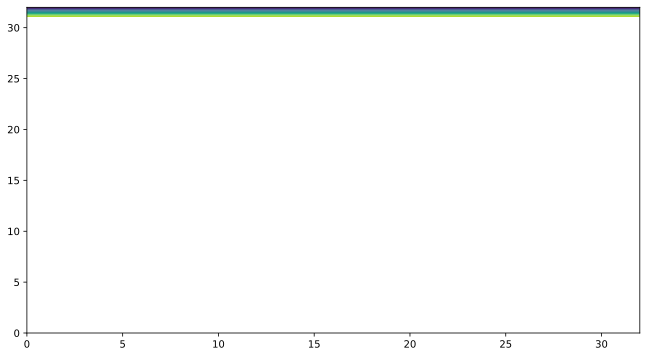

In [7]:
# Plotting initial contour
plt.figure(figsize = (11,6))
plt.contour(omg_sol[0])

In [8]:
start = time.time()
t = 0
while t < tf:
    
    # Solving the Poisson equation
    ω_n = omg_sol[-1].copy()
    itr = 0
    err = 100
    ψ_ks = psi_sol[-1].copy()
    while err > ϵ and itr < max_itr:
        # Storing latest psi for error computation
        ψ_k = ψ_ks.copy()
        
        # Looping over interior points 1 to nx-1 and 1 to nx-2
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                rhs_1 = (((dx*dy)**2)*ω_n[j, i] + (ψ_ks[j, i+1] + ψ_ks[j, i-1])*dy*dy + (ψ_ks[j+1, i]+ψ_ks[j-1, i])*dx*dx)*A
                ψ_ks[j, i] = rhs_1 + (1-β)*ψ_ks[j, i]
        err = np.linalg.norm(ψ_ks - ψ_k)
        itr+=1
    psi_sol.append(ψ_ks)

    # Solving the vorticity transport equation
    ω_n1 = ω_n.copy()
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            conv = ((0.25*dt)/(dx*dy))*((ψ_ks[j, i+1] - ψ_ks[j, i-1])*(ω_n[j+1, i] - ω_n[j-1, i])
            - (ψ_ks[j+1, i] - ψ_ks[j, i-1])*(ω_n[j, i+1] - ω_n[j, i-1]))
            
            diff = ν*dt*((ω_n[j, i+1] + ω_n[j, i-1])/(dx*dx) + (ω_n[j+1, i] + ω_n[j-1, i])/(dy*dy))
            coef = 1 - 2*ν*dt*((1/(dx*dx)) + (1/(dy*dy)))
            ω_n1[j, i] = conv + diff + ω_n[j, i]*coef
    
    # Update boundary conditions of vorticity
    ω_n1[1:-1, 0] = (-2*ψ_ks[1:-1, 1])/(dx*dx) # Left wall 
    ω_n1[1:-1, -1] = (-2*ψ_ks[1:-1, -2])/(dx*dx) # Right wall
    ω_n1[0, 1:-1] = (-2*ψ_ks[1, 1:-1])/(dy*dy) # Bottom wall
    ω_n1[-1, 1:-1] = (-2*ψ_ks[-2, 1:-1])/(dy*dy) - (2*ut)/dy # Top wall
    
    omg_sol.append(ω_n1)
    
    # Computing the velocities
    ψ = psi_sol[-1]
    u = np.zeros([ny, nx])
    v = np.zeros([ny, nx])
    u[-1, :] = ut
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            u[j, i] = (ψ[j+1, i] - ψ[j-1, i])/(2*dy)
            v[j, i] = (-1)*(ψ[j, i+1] - ψ[j, i-1])/(2*dx)
    vel_t = np.sqrt(u**2 + v**2)
    vel_sol.append(vel_t)
    u_sol.append(u)
    v_sol.append(v)
    
    time.sleep(dt)
    t+=dt
    progress = t / tf  # Calculate progress as a percentage
    update_progress_bar(int(t/dt), ts)

update_progress_bar(ts, ts)
end = time.time() - start
print(f'\nTime taken for simulation: {round(end, 3)}s')

Time step: [==================================================] 410/410 (100.00%)
Time taken for simulation: 8.418s


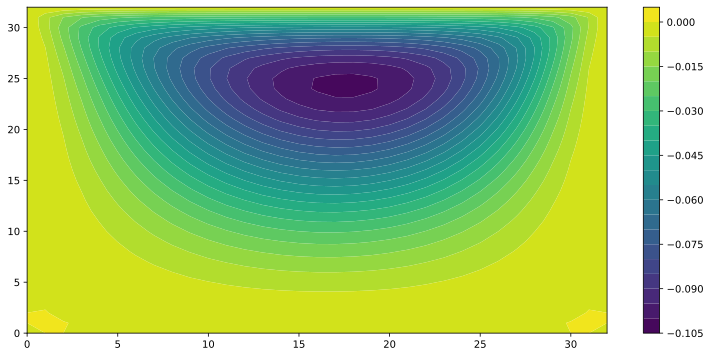

In [9]:
# Final stream-functions solution
plt.figure(figsize = (13,6))
plt.contourf(psi_sol[-1], levels=20)
plt.colorbar()
plt.show()

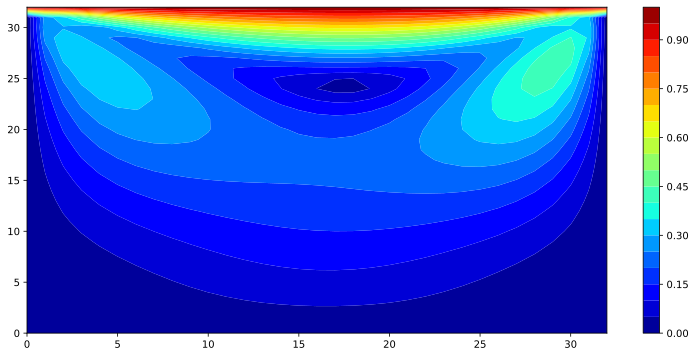

In [10]:
# Final velocity solution
plt.figure(figsize = (13,6))
plt.contourf(vel_sol[-1], cmap = plt.cm.jet, levels=20)
plt.colorbar()
plt.show()

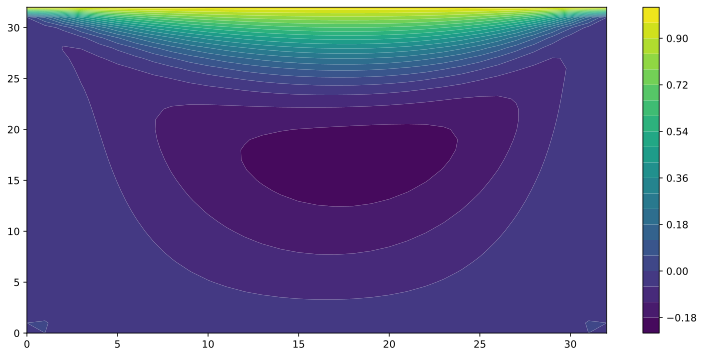

In [11]:
# x-velocity
plt.figure(figsize = (13,6))
plt.contourf(u_sol[-1], levels=20)
plt.colorbar()
plt.show()

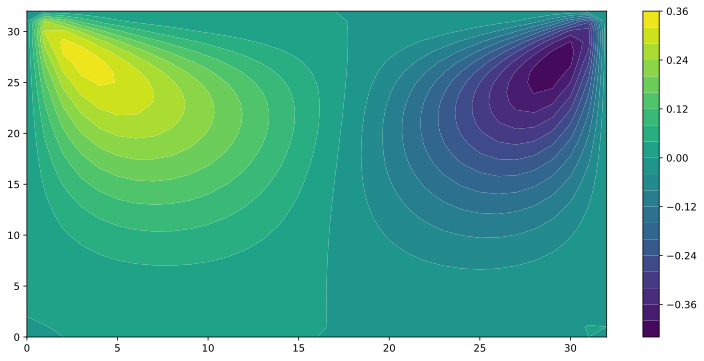

In [12]:
# y-velocity
plt.figure(figsize = (13,6))
plt.contourf(v_sol[-1], levels=20)
plt.colorbar()
plt.show()

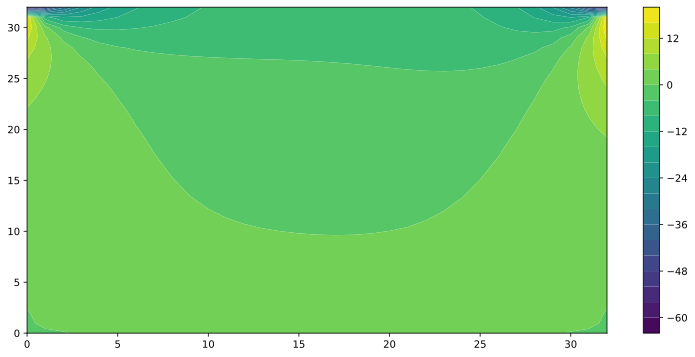

In [13]:
# Vorticity
plt.figure(figsize = (13,6))
plt.contourf(omg_sol[-1], levels=20)
plt.colorbar()
plt.show()

How to install FFMPEG for animation: https://suryadayn.medium.com/error-requested-moviewriter-ffmpeg-not-available-easy-fix-9d1890a487d3

FFMPEG builds (download the "full" version): https://www.gyan.dev/ffmpeg/builds/

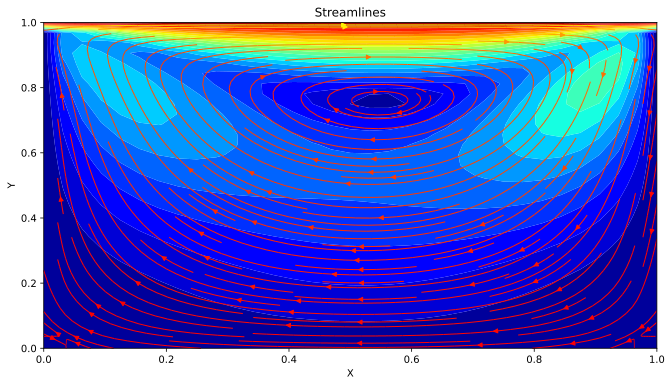

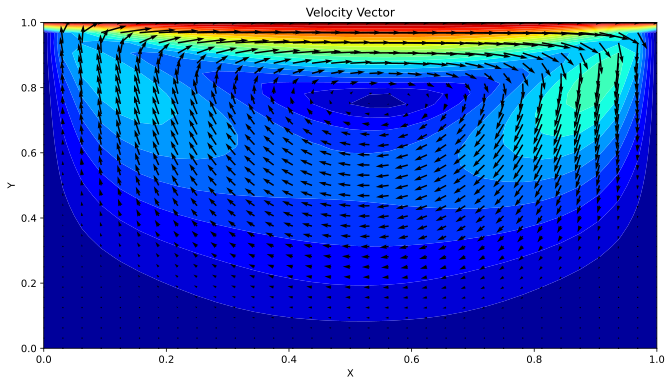

In [17]:
# Streamline
frame = -1
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize = (11, 6))
ax.contourf(X, Y, vel_sol[frame], cmap = plt.cm.jet, levels = 20)
ax.streamplot(X, Y, u_sol[frame], v_sol[frame], color = vel_sol[frame], cmap = plt.cm.autumn, density=1.5, linewidth=1, arrowsize=1)
ax.set(xlabel = 'X', ylabel = 'Y', title = 'Streamlines', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])
plt.show()

# Vector
fig, ax = plt.subplots(figsize = (11, 6))
ax.contourf(X, Y, vel_sol[frame], cmap = plt.cm.jet, levels = 20)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html
ax.quiver(X, Y, u_sol[frame], v_sol[frame], scale=10)
ax.set(xlabel = 'X', ylabel = 'Y', title = 'Velocity Vector', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])
plt.show()

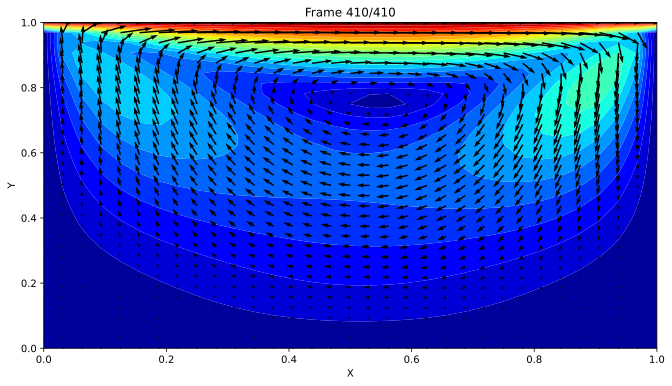

In [21]:
# Vector animation
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize = (11, 6))
def update(frame):
    ax.clear()  # Clear the previous plot
    ax.contourf(X, Y, vel_sol[frame], cmap = plt.cm.jet, levels = 20)
    ax.quiver(X, Y, u_sol[frame], v_sol[frame], scale=10)
    ax.set(xlabel = 'X', ylabel = 'Y', title = f'Frame {frame + 1}/{len(vel_sol)}', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])

animation = anm.FuncAnimation(fig, update, frames=list(range(0, len(vel_sol), int(len(vel_sol)/100)))+[len(vel_sol)-1], repeat=False)
animation

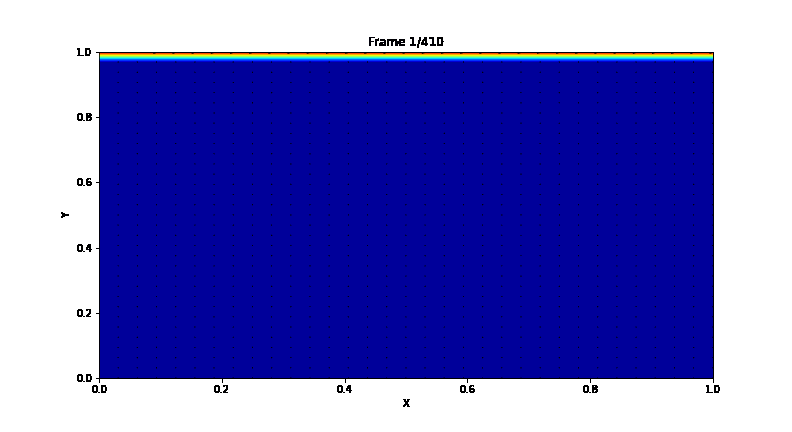

In [19]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [22]:
animation.save('vector_animation.gif', writer = 'pillow', fps = 10)

- Streamlines looked a bit off initially. More like equipotential lines, since they look perpendicular to constant stream-function lines. It seems I used $\partial\psi/\partial x$ without the negative sign for y component of velocity.
- Quite obviously, the Boundary Conditions for this scheme are physically difficult to comprehend or arrive at, unlike the velocity and pressure Boundary conditions. Also, it is made further difficult in 3 dimensions